In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import warnings

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')

In [2]:
import os

for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        print(f'./{dirname}/{filename}')

./input/real_estate_price_prediction_moscow/sample_submission.csv
./input/real_estate_price_prediction_moscow/test.csv
./input/real_estate_price_prediction_moscow/train.csv


In [3]:
TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


In [5]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B


In [8]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [9]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

In [10]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Healthcare_2       int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
# type conversion
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### 1. EDA

In [50]:
# error corection in titles and delete id исправление ошибок
train_df.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)        
train_df.head(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


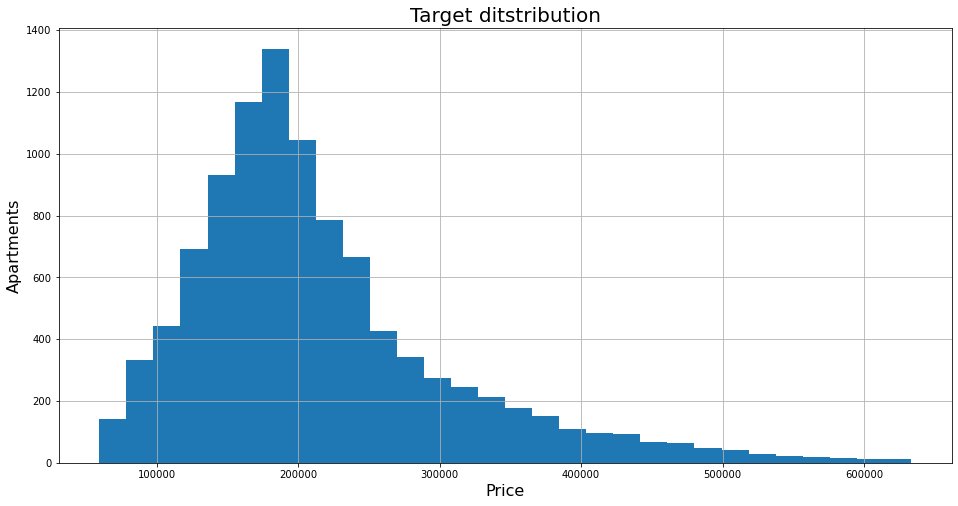

In [28]:
plt.figure(figsize=(16, 8))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Apartments', fontsize=16)
plt.title('Target ditstribution', fontsize=20)
plt.show()

#### ~ Quantitative variables

In [30]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,1984.863800,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,18.409979,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### ~ Nominative variables

In [47]:
train_df.select_dtypes(include='object').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [46]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [45]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [48]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [49]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Processing of emissions

#### Rooms

In [52]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [51]:
a = df['HouseYear'] 
b = df['Rooms']
plt.figure(figsize=(15, 6))
plt.scatter(a, b, s=5)

NameError: name 'df' is not defined

In [ ]:
district_mean_rooms = df.groupby('DistrictId')[['Rooms', 'Square']].sum()
district_mean_rooms = pd.DataFrame(district_mean_rooms['Square'] / district_mean_rooms['Rooms'])
district_mean_rooms.rename(columns={0: 'MeanValueRooms'}, inplace=True)
df = df.merge(district_mean_rooms, on=['DistrictId'])

#### HouseYear

In [12]:
train_df.loc[
    ((train_df['HouseYear'] > 2020) | (train_df['HouseYear'] < 1900)), 'HouseYear'] = int(train_df['HouseYear'].median())

#### Square, LifeSquare

In [13]:
df.loc[df['Square'] > 300, 'Square'] = df['Square'].median()
df.loc[df['LifeSquare'] > 300, 'LifeSquare'] = df['LifeSquare'].median()

NameError: name 'df' is not defined

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)


x = df['HouseYear'] 
y1 = df['LifeSquare']
y2 = df['Square']

ax1.scatter(x, y1, c='b', alpha=0.5, s=4)
ax1.scatter(x, y2, c='r', alpha=0.5, s=4)
plt.show()

#### KitchenSquare

In [ ]:
df.loc[df['KitchenSquare'] > 300, 'KitchenSquare'] = df['KitchenSquare'].median()
a = df['HouseYear'] 
b = df['KitchenSquare']
plt.figure(figsize=(15, 6))
plt.scatter(a, b, s=5)

#### HouseFloor

In [ ]:

df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df[df['HouseFloor'] == 0]['Floor']
df = df.astype({'HouseFloor': int})

#### Floor

In [ ]:
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df[df['Floor'] > df['HouseFloor']]['HouseFloor']

fig = plt.figure(figsize=(15, 6))
ax2 = fig.add_subplot()


x = df['HouseYear'] 
y1 = df['Floor']
y2 = df['HouseFloor']

ax2.scatter(x, y1, c='b', alpha=0.5, s=4)
ax2.scatter(x, y2, c='r', alpha=0.5, s=4)
plt.show()

## 2. NaN

In [ ]:
df.describe()
# NaN in LifeSquare 10000 - 7887 = 2113
# NaN in Healthcare_1 10000 - 5202 = 4798

#### LifeSquare

Find ratio lifeSquare / Square; (by districts) \
Ratio will use for replace NaN LifeSquare

In [ ]:
# Select rows with normal 'LifeSquare', where LifeSquare <= Square and 'LifeSquare' != NaN
df_ls = df[~(df['LifeSquare'].isna()) | (df['LifeSquare'] <= df['Square'])]
df_ls.shape

In [ ]:
# Create ratio lifeSquare / square (for replace NaN LifeSquare) (by DistrictId)
district_sq_mean = df_ls.groupby('DistrictId').mean()['Square']
district_lsq_mean = df_ls.groupby('DistrictId').mean()['LifeSquare']

k_mean_life_square = district_lsq_mean / district_sq_mean

k_mean_life_square = pd.DataFrame(k_mean_life_square)
k_mean_life_square.rename(columns={0: 'MeanLifeSquare'}, inplace=True)

In [ ]:
df = df.merge(k_mean_life_square, on=['DistrictId'])

In [ ]:
df.loc[(df['LifeSquare'].isna()) | (df['LifeSquare'] > df['Square']), 'LifeSquare'] = \
df.loc[(df['LifeSquare'].isna()) | (df['LifeSquare'] > df['Square']), 'Square'] * df.loc[(df['LifeSquare'].isna()) | (df['LifeSquare'] > df['Square']), 'MeanLifeSquare']

#### Healthcare_1

In [ ]:
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['Healthcare_1'].median()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xscale('linear')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.scatter(df['Price'], df['Healthcare_1'], s=4)
plt.show()